[Deep Learning Summer School 2019](http://2019.dl-lab.eu) in Gdansk, Poland  
Ordinal Regression Tutorial by [Sebastian Raschka](https://sebastianraschka.com)  
GitHub Repository: https://github.com/rasbt/DL-Gdansk2019-tutorial  

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.8
IPython 7.2.0

torch 1.1.0


## Imports

In [2]:
import time
import os
import pandas as pd
import numpy as np
import torch

from PIL import Image
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## General Settings

In [3]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 32

DEVICE = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

## Dataset

In [4]:
TRAIN_CSV_PATH = 'training_set.csv'
TEST_CSV_PATH = 'test_set.csv'
IMAGE_PATH = 'UTKFace'

In [5]:
from dataloader import UTKDatasetAgeBinary

In [6]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
NUM_CLASSES = np.unique(df_train['age'].values).shape[0]


train_indices = torch.arange(0, df_train.shape[0]-1000).numpy()
valid_indices = torch.arange(df_train.shape[0]-1000, df_train.shape[0]).numpy()
del df_train



train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)



train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.RandomCrop((120, 120)),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.CenterCrop((120, 120)),
                                     transforms.ToTensor()])


train_dataset = UTKDatasetAgeBinary(csv_path=TRAIN_CSV_PATH,
                                    img_dir=IMAGE_PATH,
                                    num_classes=NUM_CLASSES,
                                    transform=train_transform)

valid_dataset = UTKDatasetAgeBinary(csv_path=TRAIN_CSV_PATH,
                                    img_dir=IMAGE_PATH,
                                    num_classes=NUM_CLASSES,
                                    transform=test_transform)

test_dataset = UTKDatasetAgeBinary(csv_path=TEST_CSV_PATH,
                                   img_dir=IMAGE_PATH,
                                   num_classes=NUM_CLASSES,
                                   transform=test_transform)
  




train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          sampler=train_sampler)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          sampler=valid_sampler)


test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)


# Checking the dataset
for images, labels, levels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 120, 120])
Image label dimensions: torch.Size([32])


## Model Setup

In [7]:
##########################
# MODEL
##########################

from vgg16 import VGG16Base


class VGG16Coral(VGG16Base):
    def __init__(self, num_classes):
        super(VGG16Coral, self).__init__(num_classes)
        
        self.classifier = nn.Sequential(
            nn.Linear(512*3*3, 4096),
            nn.ReLU(),   
            nn.Linear(4096, 4096),
            nn.ReLU(),
            #############################################
            # Old (Niu et al.):
            #nn.Linear(4096, (self.num_classes-1)*2)
            # New (CORAL):
            nn.Linear(4096, 1, bias=False)
            #############################################
        )
        
        # New:
        self.linear_1_bias = nn.Parameter(torch.zeros(self.num_classes-1).float())

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)

        logits = self.classifier(x.view(x.size(0), -1))
        
        
        ###################################################
        # Old (Niu et al.):
        #logits = logits.view(-1, (self.num_classes-1), 2)
        # probas = F.softmax(logits, dim=2)[:, :, 1]
        
        
        # New (CORAL):
        #############################################################################
        ##########################################
        ## EXERCISE: Complete the following 2
        ## lines of code
        ##########################################
        
        logits = # ???
        probas = # ???
        #############################################################################
        
        return logits, probas

### Initialize the Model

In [8]:
###########################################
# Initialize Cost, Model, and Optimizer
###########################################

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
model = VGG16Coral(NUM_CLASSES)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

IMPORTANCE_WEIGHT = torch.ones(NUM_CLASSES-1, dtype=torch.float)
IMPORTANCE_WEIGHT = IMPORTANCE_WEIGHT.to(DEVICE)

#######################################################################################
# Old (Niu et al):
#def cost_fn(logits, levels, imp):
#    val = (-torch.sum((F.log_softmax(logits, dim=2)[:, :, 1]*levels
#                      + F.log_softmax(logits, dim=2)[:, :, 0]*(1-levels))*imp, dim=1))
#    return torch.mean(val)

# New (CORAL): 
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)
#######################################################################################

## Model Training

In [9]:
def compute_mae_mse_acc(model, data_loader, device):
    mae, mse, acc, num_examples = 0., 0., 0, 0
    for i, (features, targets, levels) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        predict_levels = probas > 0.5
        predicted_labels = torch.sum(predict_levels, dim=1)
        
        num_examples += targets.size(0)
        acc += torch.sum(predicted_labels == targets)
        mae += torch.sum(torch.abs(predicted_labels - targets))
        mse += torch.sum((predicted_labels - targets)**2)
    acc = acc.float() / num_examples   
    mae = mae.float() / num_examples
    mse = mse.float() / num_examples
    return mae, mse, acc

In [10]:
start_time = time.time()

# use random seed for reproducibility (here batch shuffling)
torch.manual_seed(RANDOM_SEED)

cost_list = []
train_mae_list, valid_mae_list = [], []
train_mse_list, valid_mse_list = [], []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets, levels) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        levels = levels.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        cost = cost_fn(logits, levels, IMPORTANCE_WEIGHT)

        optimizer.zero_grad()        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 25:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

            
    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        
        train_mae, train_mse, train_acc = compute_mae_mse_acc(
                model, train_loader, device=DEVICE)
        valid_mae, valid_mse, valid_acc = compute_mae_mse_acc(
                model, valid_loader, device=DEVICE)
 
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train MAE: {train_mae:.2f} | Validation MAE: {valid_mae:.2f}')
        
        train_mae_list.append(train_mae)
        valid_mae_list.append(valid_mae)
        train_mse_list.append(train_mse)
        valid_mse_list.append(valid_mse)
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/100 | Batch 000/381 | Cost: 27.0170
Epoch: 001/100 | Batch 025/381 | Cost: 25.6690
Epoch: 001/100 | Batch 050/381 | Cost: 24.6715
Epoch: 001/100 | Batch 075/381 | Cost: 25.7692
Epoch: 001/100 | Batch 100/381 | Cost: 24.9233
Epoch: 001/100 | Batch 125/381 | Cost: 25.2413
Epoch: 001/100 | Batch 150/381 | Cost: 24.9388
Epoch: 001/100 | Batch 175/381 | Cost: 25.2473
Epoch: 001/100 | Batch 200/381 | Cost: 25.5140
Epoch: 001/100 | Batch 225/381 | Cost: 24.3154
Epoch: 001/100 | Batch 250/381 | Cost: 24.1585
Epoch: 001/100 | Batch 275/381 | Cost: 26.1642
Epoch: 001/100 | Batch 300/381 | Cost: 24.8138
Epoch: 001/100 | Batch 325/381 | Cost: 24.6863
Epoch: 001/100 | Batch 350/381 | Cost: 25.1982
Epoch: 001/100 | Batch 375/381 | Cost: 25.4531
Epoch: 001/100
Train MAE: 13.93 | Validation MAE: 13.69
Time elapsed: 1.33 min
Epoch: 002/100 | Batch 000/381 | Cost: 26.7030
Epoch: 002/100 | Batch 025/381 | Cost: 25.2493
Epoch: 002/100 | Batch 050/381 | Cost: 24.5605
Epoch: 002/100 | Batch 075/3

## Evaluation

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

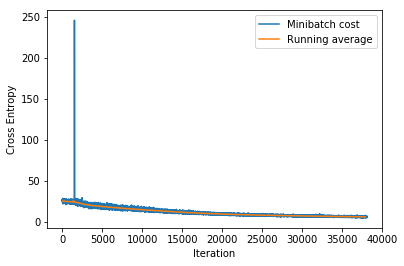

In [12]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

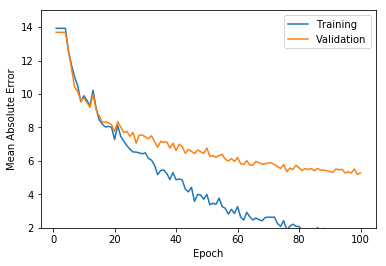

In [13]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_mae_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_mae_list, label='Validation')
plt.ylim(2, 15)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

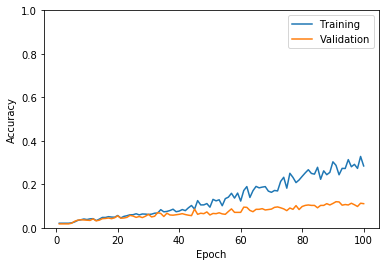

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
with torch.set_grad_enabled(False):
    test_mae, test_mse, test_acc = compute_mae_mse_acc(model=model,
                                                       data_loader=test_loader,
                                                       device=DEVICE)
    
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MSE: {torch.sqrt(test_mse):.2f}')
print(f'Test ACC: {test_acc*100:.2f}%')

Test MAE: 5.63
Test MSE: 7.71
Test ACC: 10.01%
